# 2b – XGBoost nur für Down (down vs. not-down)

Dieses Notebook trainiert ein binäres XGBoost-Modell, das nur vorhersagt,
ob der Kurs **fällt** (`down`) oder **nicht fällt** (`neutral` oder `up`).

Es verwendet denselben Datensatz, dieselben Splits und dieselben Features wie
das Zwei-Stufen-Notebook `2_train_xgboost_two_stage.ipynb`, damit die
Ergebnisse gut vergleichbar sind.

## 1. Experiment-Konfiguration

- `EXP_ID` bestimmt, welche Label-/Datensatz-Variante verwendet wird.
- Es wird die Datei
  `data/processed/datasets/eurusd_news_training__<EXP_ID>.csv` geladen.
- Die Labels (`label`, `signal`, `direction`, `lookahead_return`) stammen
  aus `1_data_prep_xgboost_two_stage.ipynb`.

In [1]:
EXP_ID = "v4_h4_thr0p5pct_tolerant0p3pct"  # hier die gewünschte EXP_ID einsetzen

## 2. Projektwurzel und Imports

Dieser Block sorgt dafür, dass wir `src/...`-Module auch aus dem
Notebook heraus importieren können.

In [2]:
import sys
from pathlib import Path

cwd = Path.cwd()
project_root = cwd
while not (project_root / "src").is_dir():
    if project_root.parent == project_root:
        raise RuntimeError("Projektwurzel mit 'src' nicht gefunden.")
    project_root = project_root.parent

print("Erkannte Projektwurzel:", project_root)
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

Erkannte Projektwurzel: /Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project


## 3. Datensatz laden und zeitlich splitten

- Wir laden den vorbereiteten Trainingsdatensatz.
- Anschließend werden Train/Val/Test wie im Zwei-Stufen-Notebook anhand
  eines Stichtags (`test_start`) erzeugt.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.models.train_xgboost_two_stage import (
    load_dataset,
    split_train_val_test,
    FEATURE_COLS,
)

plt.style.use("seaborn-v0_8")

dataset_path = project_root / f"data/processed/datasets/eurusd_news_training__{EXP_ID}.csv"
df = load_dataset(dataset_path)

print("Datensatz:", dataset_path)
print(df.shape)
df.head()

Datensatz: /Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/data/processed/datasets/eurusd_news_training__v4_h4_thr0p5pct_tolerant0p3pct.csv
(1163, 41)


,date,label,signal,direction,month,week,quarter,intraday_range,intraday_range_pct,body,...,cal_is_month_end,hol_is_us_federal_holiday,hol_is_day_before_us_federal_holiday,hol_is_day_after_us_federal_holiday,lookahead_return,article_count,avg_polarity,avg_neg,avg_neu,avg_pos
0,2020-04-14,neutral,0,NaN,4,16,2,0.006822,0.006246,0.000346,...,0,0,0,0,-0.005129,1,-0.949,0.0930,0.8410,0.0660
1,2020-05-28,up,1,1.0,5,22,2,0.007875,0.007148,0.000158,...,0,0,0,0,0.015665,1,0.518,0.0870,0.8200,0.0940
2,2020-07-15,neutral,0,NaN,7,29,3,0.005945,0.005210,-0.000013,...,0,0,0,0,0.004205,1,0.847,0.0800,0.8180,0.1020
3,2020-07-22,up,1,1.0,7,30,3,0.009239,0.008010,-0.000106,...,0,0,0,0,0.020396,2,0.925,0.0870,0.7850,0.1280
4,2020-10-19,up,1,1.0,10,43,4,0.009029,0.007707,-0.000014,...,0,0,0,0,0.008495,4,0.944,0.0615,0.8515,0.0865


In [4]:
print("Label-Verteilung (neutral/up/down):")
print(df["label"].value_counts())

test_start = "2025-01-01"
train_frac_pretest = 0.8  # 80 % Train, 20 % Val vor test_start

splits = split_train_val_test(
    df,
    pd.to_datetime(test_start),
    train_frac_within_pretest=train_frac_pretest,
)

for name, split_df in splits.items():
    print(f"{name}: {split_df['date'].min().date()} → {split_df['date'].max().date()} (n={len(split_df)})")

Label-Verteilung (neutral/up/down):
label
neutral    624
down       277
up         262
Name: count, dtype: int64
train: 2020-04-14 → 2024-04-09 (n=756)
val: 2024-04-10 → 2024-12-31 (n=189)
test: 2025-01-02 → 2025-11-05 (n=218)


## 4. Zielvariable `down` vs. `not-down` bauen

- Binär-Variable:
  - 1 = `label == 'down'`
  - 0 = `label != 'down'` (neutral oder up).

In [5]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def build_down_target(df: pd.DataFrame):
    """Zielvariable: 1 = down, 0 = nicht-down (neutral oder up)."""
    return (df["label"] == "down").astype(int).to_numpy()

y_train_down = build_down_target(splits["train"])
y_val_down   = build_down_target(splits["val"])
y_test_down  = build_down_target(splits["test"])

X_train = splits["train"][FEATURE_COLS]
X_val   = splits["val"][FEATURE_COLS]
X_test  = splits["test"][FEATURE_COLS]

print("Train/Val/Test Shapes:", X_train.shape, X_val.shape, X_test.shape)

Train/Val/Test Shapes: (756, 32) (189, 32) (218, 32)


## 5. Down-Modell trainieren

- Wir verwenden dieselben XGBoost-Parameter wie im Zwei-Stufen-Richtungsmodell.
- `scale_pos_weight` kompensiert die Imbalance zwischen down und not-down.

In [6]:
import xgboost as xgb
import numpy as np

# Klassenverhältnis für scale_pos_weight (gegen Imbalance)
n_pos = int((y_train_down == 1).sum())
n_neg = int((y_train_down == 0).sum())
scale_pos_weight = n_neg / max(n_pos, 1)
print("n_neg:", n_neg, "n_pos:", n_pos, "scale_pos_weight:", scale_pos_weight)

model_down = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    max_depth=3,
    learning_rate=0.05,
    n_estimators=400,
    subsample=0.9,
    colsample_bytree=0.9,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
)

model_down.fit(
    X_train,
    y_train_down,
    eval_set=[(X_val, y_val_down)],
    early_stopping_rounds=50,
    verbose=False,
)

model_down

n_neg: 569 n_pos: 187 scale_pos_weight: 3.0427807486631018


/Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/.venv/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

## 6. Auswertung: Train / Val / Test

Wir evaluieren das Modell auf allen drei Splits und betrachten speziell die
`down`-Klasse (1).


=== TRAIN (DOWN vs NOT-DOWN) ===
Accuracy gesamt: 0.886
Classification Report (0=not-down, 1=down):
              precision    recall  f1-score   support

           0      0.974     0.872     0.920       569
           1      0.704     0.930     0.802       187

    accuracy                          0.886       756
   macro avg      0.839     0.901     0.861       756
weighted avg      0.908     0.886     0.891       756



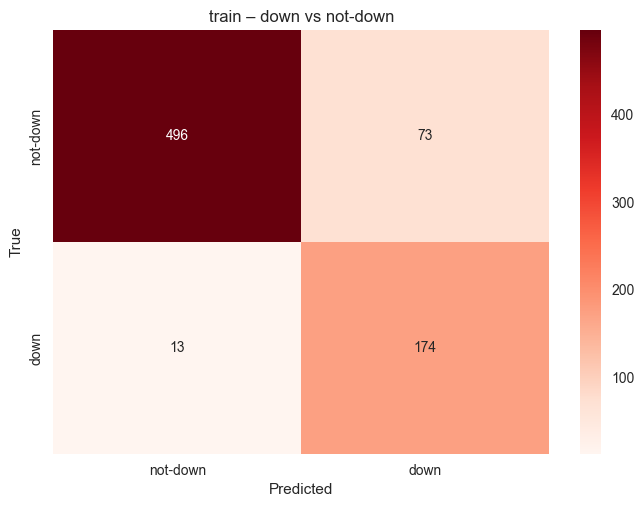


=== VAL (DOWN vs NOT-DOWN) ===
Accuracy gesamt: 0.741
Classification Report (0=not-down, 1=down):
              precision    recall  f1-score   support

           0      0.833     0.828     0.830       145
           1      0.444     0.455     0.449        44

    accuracy                          0.741       189
   macro avg      0.639     0.641     0.640       189
weighted avg      0.743     0.741     0.742       189



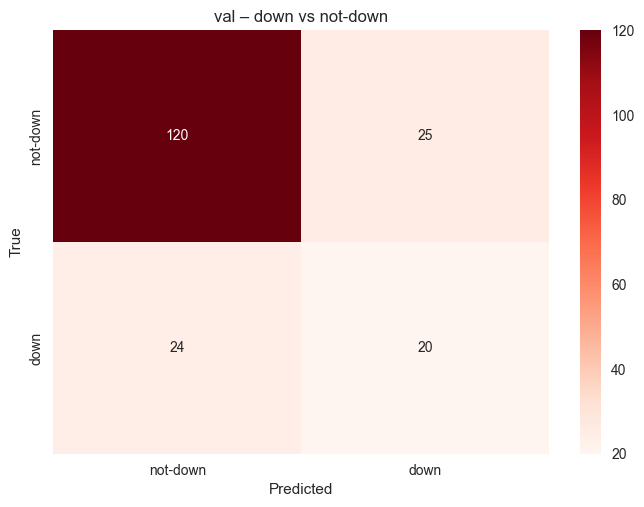


=== TEST (DOWN vs NOT-DOWN) ===
Accuracy gesamt: 0.683
Classification Report (0=not-down, 1=down):
              precision    recall  f1-score   support

           0      0.860     0.715     0.781       172
           1      0.347     0.565     0.430        46

    accuracy                          0.683       218
   macro avg      0.603     0.640     0.605       218
weighted avg      0.752     0.683     0.707       218



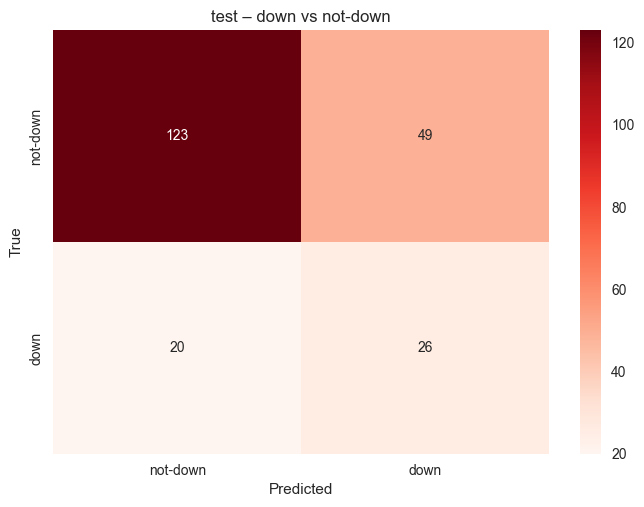

In [7]:
def eval_binary_split(name, model, X, y_true):
    """Hilfsfunktion: Accuracy, Report und Confusion-Matrix ausgeben."""
    if len(X) == 0:
        print(f"[warn] Split {name} leer.")
        return

    y_prob = model.predict_proba(X)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)  # 1=down, 0=not-down

    acc = accuracy_score(y_true, y_pred)
    print(f"\n=== {name.upper()} (DOWN vs NOT-DOWN) ===")
    print(f"Accuracy gesamt: {acc:.3f}")

    print("Classification Report (0=not-down, 1=down):")
    print(classification_report(y_true, y_pred, digits=3))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Reds",
        xticklabels=["not-down", "down"],
        yticklabels=["not-down", "down"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{name} – down vs not-down")
    plt.show()

eval_binary_split("train", model_down, X_train, y_train_down)
eval_binary_split("val",   model_down, X_val,   y_val_down)
eval_binary_split("test",  model_down, X_test,  y_test_down)

## 7. Metriken speichern (JSON + CSV)

Analog zum Zwei-Stufen-Notebook speichern wir die wichtigsten Kennzahlen
für Train/Val/Test als JSON und als flache CSV-Tabelle.

In [8]:
from pathlib import Path
import json

results_dir = project_root / "notebooks" / "results"
results_dir.mkdir(parents=True, exist_ok=True)

out_path = results_dir / f"down_only__{EXP_ID}.json"

In [9]:
def binary_metrics_dict(y_true, y_prob, threshold):
    """Metriken + Confusion-Matrix für ein Binärmodell berechnen."""
    y_pred = (y_prob >= threshold).astype(int)
    report = classification_report(y_true, y_pred, output_dict=True, digits=3)
    cm = confusion_matrix(y_true, y_pred).tolist()
    return {
        "threshold": float(threshold),
        "report": report,
        "confusion_matrix": cm,
    }

p_train_down = model_down.predict_proba(X_train)[:, 1]
p_val_down   = model_down.predict_proba(X_val)[:, 1]
p_test_down  = model_down.predict_proba(X_test)[:, 1]

down_metrics = {
    "train": binary_metrics_dict(y_train_down, p_train_down, threshold=0.5),
    "val":   binary_metrics_dict(y_val_down,   p_val_down,   threshold=0.5),
    "test":  binary_metrics_dict(y_test_down,  p_test_down,  threshold=0.5),
}

results = {
    "config": {
        "exp_id": EXP_ID,
        "task": "down_vs_not_down",
        "dataset_path": str(dataset_path),
        "feature_cols": FEATURE_COLS,
        "test_start": test_start,
        "train_frac_within_pretest": train_frac_pretest,
    },
    "down_model": down_metrics,
}

with out_path.open("w") as f:
    json.dump(results, f, indent=2)

print("[ok] Ergebnisse gespeichert unter:", out_path)

[ok] Ergebnisse gespeichert unter: /Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/notebooks/results/down_only__v4_h4_thr0p5pct_tolerant0p3pct.json


In [10]:
# Kompakte CSV-Zusammenfassung (pro Split nur die Kennzahlen der down-Klasse)
rows = []
for split_name, m in down_metrics.items():
    rep = m["report"]["1"]  # Klasse 1 = down
    rows.append(
        {
            "split": split_name,
            "class": "down",
            "precision": rep["precision"],
            "recall": rep["recall"],
            "f1": rep["f1-score"],
            "support": rep["support"],
        }
    )

summary_down = pd.DataFrame(rows)
metrics_path = results_dir / f"down_only__{EXP_ID}_metrics.csv"
summary_down.to_csv(metrics_path, index=False)
print("[ok] Metrik-Tabelle gespeichert unter:", metrics_path)

display(summary_down)

[ok] Metrik-Tabelle gespeichert unter: /Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/notebooks/results/down_only__v4_h4_thr0p5pct_tolerant0p3pct_metrics.csv


,split,class,precision,recall,f1,support
0,train,down,0.704453,0.930481,0.801843,187.0
1,val,down,0.444444,0.454545,0.449438,44.0
2,test,down,0.346667,0.565217,0.429752,46.0


## 8. Fehlklassifizierte Down-Fälle visualisieren

Wir möchten verstehen, wie die Kursverläufe an Tagen aussehen,
an denen das Down-Modell falsch lag:

- **False Negatives**: echte down-Tage, die als not-down klassifiziert wurden.
- **False Positives**: echte nicht-down-Tage, die als down klassifiziert wurden.

Dazu verbinden wir den Test-Split wieder mit den ursprünglichen Preisen
(`Close`) aus der Label-Datei und zeichnen die Segmente t..t+4 Handelstage.

In [11]:
labels_path = project_root / "data" / "processed" / "fx" / f"eurusd_labels__{EXP_ID}.csv"
df_labels = pd.read_csv(labels_path, parse_dates=["Date"]).rename(columns={"Date": "date"})
df_labels = df_labels.sort_values("date").set_index("date")

print(labels_path, df_labels.shape)
df_labels.head()

/Users/jeremynathan/Documents/GitHub/hs2025_ml_project/hs2025_ml_project/data/processed/fx/eurusd_labels__v4_h4_thr0p5pct_tolerant0p3pct.csv (2824, 7)


,Close,High,Low,Open,Volume,lookahead_return,label
date,,,,,,,
2015-01-01,1.209863,1.209863,1.209863,1.209863,0,-0.018454,down
2015-01-02,1.208941,1.208956,1.201080,1.208868,0,-0.020962,down
2015-01-05,1.194643,1.197590,1.188909,1.195500,0,-0.012586,down
2015-01-06,1.193902,1.197000,1.188693,1.193830,0,-0.005722,down
2015-01-07,1.187536,1.190000,1.180401,1.187479,0,-0.003691,neutral


In [12]:
# Test-Split mit Preisen joinen
df_test = splits["test"].merge(
    df_labels[["Close"]],
    left_on="date",
    right_index=True,
    how="left",
)

# Wahrscheinlichkeiten und harte Vorhersage für down
df_test["y_true_down"] = y_test_down
df_test["p_down"] = model_down.predict_proba(X_test)[:, 1]
df_test["y_pred_down"] = (df_test["p_down"] >= 0.5).astype(int)  # 1=down, 0=not-down

# Startkurs und Kurs in 4 Tagen (aus lookahead_return)
df_test["close_t"] = df_test["Close"]
df_test["close_t_plus4"] = df_test["Close"] * (1 + df_test["lookahead_return"])

In [13]:
# False Negatives: echte down (1), aber als not-down vorhergesagt (0)
fn_down = df_test[(df_test["y_true_down"] == 1) & (df_test["y_pred_down"] == 0)].sort_values("date")

# False Positives: echte nicht-down (0), aber als down vorhergesagt (1)
fp_down = df_test[(df_test["y_true_down"] == 0) & (df_test["y_pred_down"] == 1)].sort_values("date")

cols = [
    "date",
    "label",
    "close_t",
    "close_t_plus4",
    "lookahead_return",
    "p_down",
    "y_true_down",
    "y_pred_down",
]

print("False Negatives (echte down, als not-down vorhergesagt):")
display(fn_down[cols].head(20))

print("False Positives (echte nicht-down, als down vorhergesagt):")
display(fp_down[cols].head(20))

False Negatives (echte down, als not-down vorhergesagt):


,date,label,close_t,close_t_plus4,lookahead_return,p_down,y_true_down,y_pred_down
948,2025-01-07,down,1.038637,1.024443,-0.013666,0.120754,1,0
962,2025-01-27,down,1.046759,1.039728,-0.006717,0.164277,1,0
963,2025-01-28,down,1.044506,1.024779,-0.018887,0.412867,1,0
964,2025-01-29,down,1.042905,1.032738,-0.009749,0.486669,1,0
965,2025-01-30,down,1.042525,1.037280,-0.005031,0.358120,1,0
969,2025-02-05,down,1.037280,1.030153,-0.006871,0.088950,1,0
998,2025-03-18,down,1.091918,1.083576,-0.007639,0.259200,1,0
1001,2025-03-21,down,1.085670,1.074206,-0.010559,0.391148,1,0
1011,2025-04-04,down,1.104374,1.095206,-0.008302,0.360279,1,0
1030,2025-05-05,down,1.132323,1.122423,-0.008744,0.198631,1,0


False Positives (echte nicht-down, als down vorhergesagt):


,date,label,close_t,close_t_plus4,lookahead_return,p_down,y_true_down,y_pred_down
950,2025-01-09,neutral,1.031470,1.030684,-0.000763,0.611214,0,1
951,2025-01-10,neutral,1.029760,1.029527,-0.000227,0.586381,0,1
958,2025-01-21,neutral,1.042068,1.046759,0.004501,0.689102,0,1
970,2025-02-06,neutral,1.040085,1.036495,-0.003452,0.580992,0,1
971,2025-02-07,neutral,1.038573,1.039199,0.000603,0.740199,0,1
979,2025-02-19,neutral,1.044834,1.046134,0.001245,0.520632,0,1
981,2025-02-21,neutral,1.050056,1.048878,-0.001122,0.556756,0,1
984,2025-02-26,neutral,1.052410,1.048504,-0.003712,0.556551,0,1
992,2025-03-10,neutral,1.086059,1.085564,-0.000456,0.501098,0,1
995,2025-03-13,neutral,1.088625,1.093948,0.004890,0.640444,0,1


### Segment-Visualisierung der Fehlklassifikationen

Wir verwenden dieselben Hilfsfunktionen wie im Up-Notebook, um
die Verläufe der fehlerhaften Down-Segmente zu plotten.


In [14]:
def plot_segments_time(df_price, start_dates, horizon_steps=4, color="red", label_name="down",
                       window_start=None, window_end=None, max_segments=None):
    """Zeitreihen-Plot mit Segmenten t..t+horizon_steps für gegebene Starttage."""
    df = df_price.sort_index()

    if window_start is not None or window_end is not None:
        mask = pd.Series(True, index=df.index)
        if window_start is not None:
            mask &= df.index >= pd.to_datetime(window_start)
        if window_end is not None:
            mask &= df.index <= pd.to_datetime(window_end)
        df_window = df[mask].copy()
    else:
        df_window = df.copy()

    start_dates = pd.to_datetime(start_dates)
    start_dates = [d for d in start_dates if d in df.index]
    if max_segments is not None:
        start_dates = start_dates[:max_segments]

    print(f"{len(start_dates)} Starttage mit label='{label_name}' im Fenster {window_start}–{window_end} ausgewählt.")

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(df_window.index, df_window['Close'], color='lightgray', linewidth=1, label='Close (gesamt)')

    idx = df.index
    for t0 in start_dates:
        pos = idx.get_loc(t0)
        end_pos = pos + horizon_steps
        if end_pos >= len(idx):
            continue
        seg = df.iloc[pos : end_pos + 1]

        ax.plot(seg.index, seg['Close'], color=color, linewidth=2, alpha=0.8)
        ax.scatter(seg.index[0], seg['Close'].iloc[0], color=color, s=30)
        ax.scatter(seg.index[-1], seg['Close'].iloc[-1], color=color, s=50, marker='x')

    ax.set_title(
        f"EURUSD-Segmente mit label='{label_name}' (horizon={horizon_steps} Handelstage)\n"
        f"Zeitraum {window_start}–{window_end}, n={len(start_dates)} Segmente"
    )
    ax.set_xlabel('Datum')
    ax.set_ylabel('Close')
    plt.tight_layout()
    plt.show()


def plot_segments_rel_small_multiples(df_price, start_dates, horizon_steps=4,
                                      max_segments=None, label_name='down'):
    """Small-Multiples: rel. Verlauf 0..horizon_steps für gegebene Starttage."""
    df = df_price.sort_index()
    idx = df.index

    start_dates = pd.to_datetime(start_dates)
    start_dates = [d for d in start_dates if d in df.index]
    if max_segments is not None:
        start_dates = start_dates[:max_segments]

    rows = []
    for t0 in start_dates:
        pos = idx.get_loc(t0)
        end_pos = pos + horizon_steps
        if end_pos >= len(idx):
            continue
        seg = df.iloc[pos : end_pos + 1]
        start_close = seg['Close'].iloc[0]
        for step, (dt, row) in enumerate(seg.iterrows()):
            rows.append({'segment_start': seg.index[0], 'step': step, 'rel_close': row['Close'] / start_close - 1.0})

    seg_df = pd.DataFrame(rows)
    if seg_df.empty:
        print('Keine Segmente zum Plotten.')
        return

    g = sns.FacetGrid(seg_df, col='segment_start', col_wrap=4, height=2.0, sharey=True)
    g.map_dataframe(sns.lineplot, x='step', y='rel_close', marker='o')
    g.set_axis_labels('Schritt (Handelstage)', 'rel_close')
    g.set_titles('{col_name}')
    plt.suptitle(f"Relativer Verlauf der Segmente (label='{label_name}')", y=1.02)
    plt.tight_layout()
    plt.show()


20 Starttage mit label='fn_down' im Fenster 2025-01-07–2025-10-31 ausgewählt.


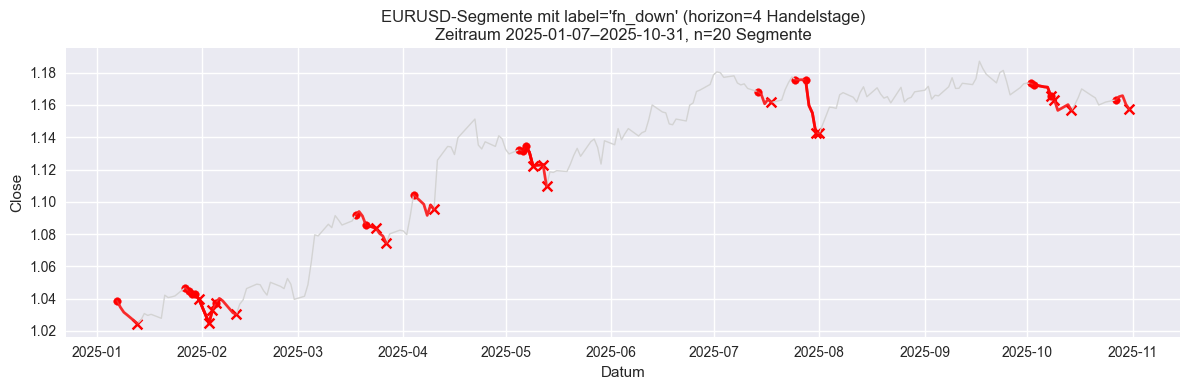

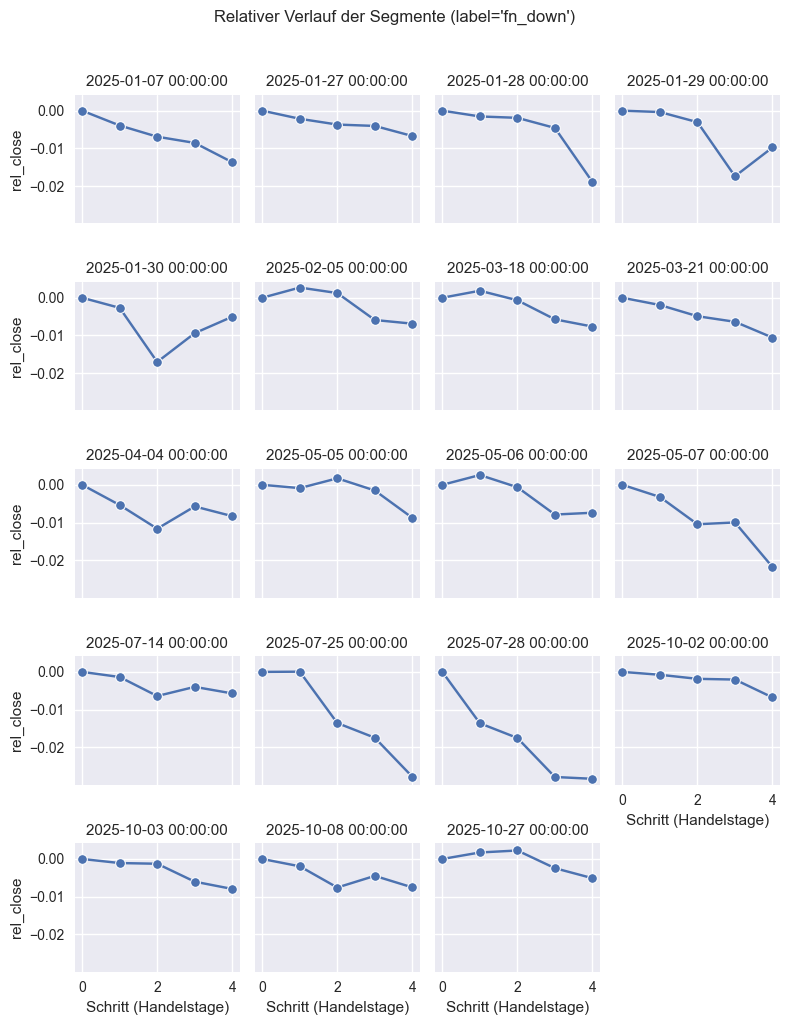

In [15]:
# Beispiel: False-Negative-down-Segmente visualisieren
fn_down_dates = fn_down["date"]
if not fn_down_dates.empty:
    window_start = fn_down_dates.min().date()
    window_end = fn_down_dates.max().date()
    plot_segments_time(
        df_labels[["Close"]],
        start_dates=fn_down_dates,
        horizon_steps=4,
        color="red",
        label_name="fn_down",
        window_start=window_start,
        window_end=window_end,
        max_segments=None,
    )
    plot_segments_rel_small_multiples(
        df_labels[["Close"]],
        start_dates=fn_down_dates,
        horizon_steps=4,
        max_segments=None,
        label_name="fn_down",
    )
else:
    print("Keine False-Negative-down-Fälle im Test-Split.")


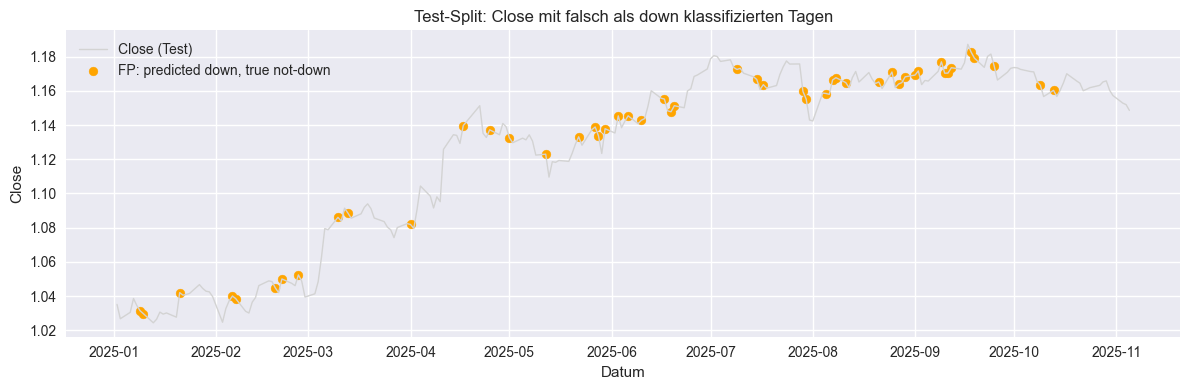

In [16]:
# Überblick: Test-Preise mit Hervorhebung falscher Down-Vorhersagen
df_test_down = df_test.copy().sort_values('date')
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df_test_down['date'], df_test_down['Close'], color='lightgray', linewidth=1, label='Close (Test)')

# Tage, an denen als down klassifiziert wurde, die aber nicht down sind (False Positives)
mask_fp = (df_test_down['y_true_down'] == 0) & (df_test_down['y_pred_down'] == 1)
ax.scatter(
    df_test_down.loc[mask_fp, 'date'],
    df_test_down.loc[mask_fp, 'Close'],
    color='orange',
    s=40,
    label='FP: predicted down, true not-down',
)

ax.set_title('Test-Split: Close mit falsch als down klassifizierten Tagen')
ax.set_xlabel('Datum')
ax.set_ylabel('Close')
ax.legend()
plt.tight_layout()
plt.show()


49 Starttage mit label='fp_down' im Fenster 2025-01-09–2025-10-13 ausgewählt.


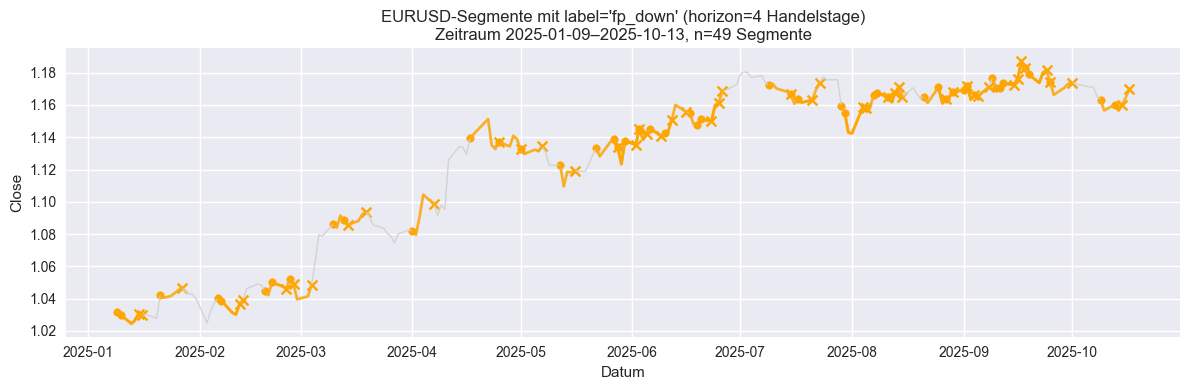

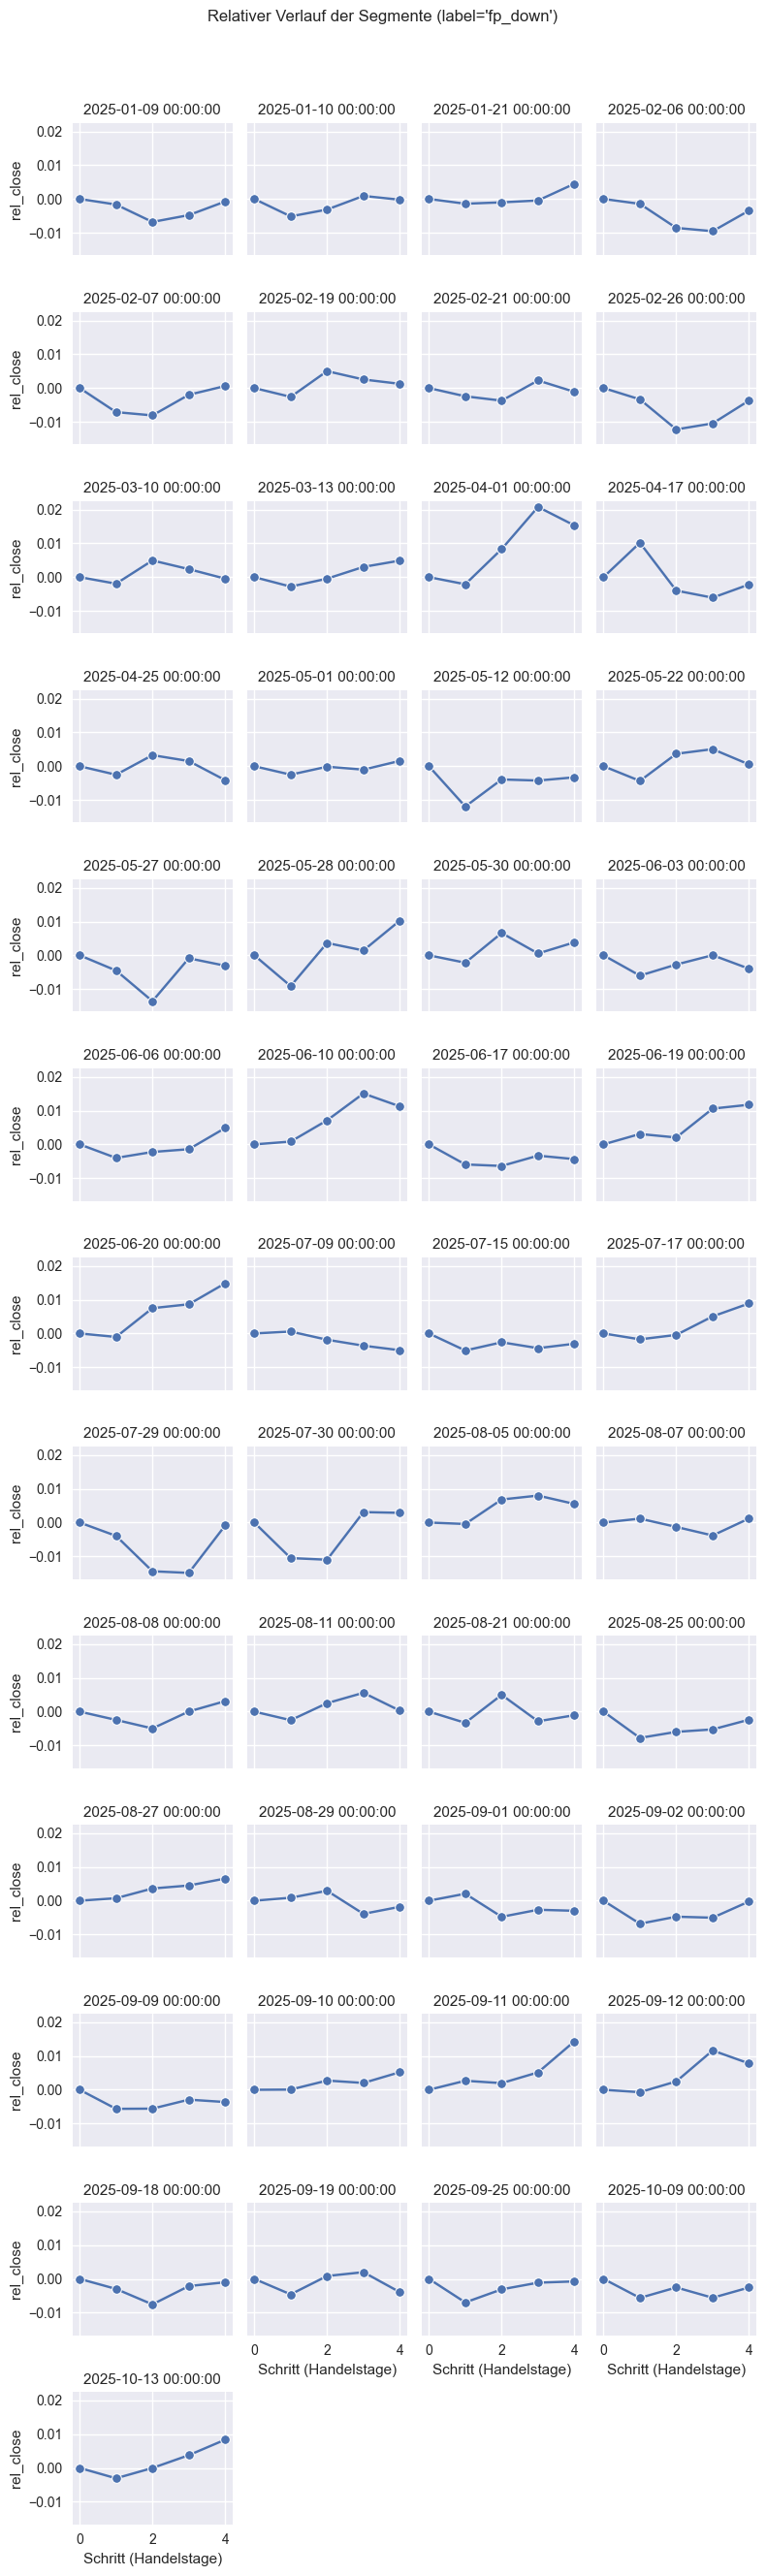

In [17]:
# Small-Multiples der False-Positive-down-Segmente
fp_down_dates = fp_down['date']
if not fp_down_dates.empty:
    window_start = fp_down_dates.min().date()
    window_end = fp_down_dates.max().date()
    plot_segments_time(
        df_labels[['Close']],
        start_dates=fp_down_dates,
        horizon_steps=4,
        color='orange',
        label_name='fp_down',
        window_start=window_start,
        window_end=window_end,
        max_segments=None,
    )
    plot_segments_rel_small_multiples(
        df_labels[['Close']],
        start_dates=fp_down_dates,
        horizon_steps=4,
        max_segments=None,
        label_name='fp_down',
    )
else:
    print('Keine False-Positive-down-Fälle im Test-Split.')
